In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import random
from torch.utils.data import Subset
seed = 92

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [2]:
class FederatedClient():
    def __init__(self, model, criterion, train_loader, val_loader=None):
        self.model = model
        #self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        
    def train(self, num_epochs, learning_rate, weight_decay, fed_alg, mu=0):
        optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()
        global_model = copy.deepcopy(self.model)
        train_loss = []
        train_acc = []
        for epoch in range(num_epochs):
            epoch_loss = 0
            epoch_acc = 0
            loss1_sum = 0
            loss2_sum = 0
            for i, (x, y) in enumerate(self.train_loader):
                #x = x.to('cuda:0')
                #y = y.to('cuda:0')
                optimizer.zero_grad()
                outputs = self.model(x)
                if(fed_alg=='fedavg'):
                    loss = self.criterion(outputs, y)
                elif(fed_alg=='fedprox'):
                    proximal_term = 0.0
                    for param, global_param in zip(self.model.parameters(), global_model.parameters()):
                        proximal_term += torch.norm(param - global_param, p=2)
                    loss1 = self.criterion(outputs, y) 
                    loss2 = mu/2 * proximal_term
                    loss = loss1 + loss2
                loss.backward()

                # Clip gradients
                #torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip_value)

                optimizer.step()
                epoch_loss += loss.item()
                epoch_acc += (outputs.argmax(1) == y).sum().item()

            train_loss.append(epoch_loss / len(self.train_loader))
            train_acc.append(epoch_acc / len(self.train_loader.dataset))
        
        return self.model, train_loss, train_acc
    
    def test(self,test_loader):
        self.model.eval()
        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for x, y in test_loader:
                outputs = self.model(x)
                loss = self.criterion(outputs, y)
                test_loss += loss.item()
                test_acc += (outputs.argmax(1) == y).sum().item()
        
        return test_loss / len(test_loader), test_acc / len(test_loader.dataset)
    
    def get_model(self):
        return self.model

def FedAvg(w,alpha):
    alpha = alpha/np.sum(alpha) #normalize alpha
    w_avg = copy.deepcopy(w[0])
    n_clients = len(w)
    
    for l in w_avg.keys():
        w_avg[l] = w_avg[l] - w_avg[l]

    for l, layer in enumerate(w_avg.keys()): #for each layer
        w_kl = []
        for k in range(0,n_clients): #for each client
            w_avg[layer] += alpha[k]*w[k][layer]
    return w_avg

def optimize_alpha(target_labels, source_labels, n_epochs, eta):
    #given a vector T(y) (target labels) and S(y) (source labels), optimize alpha with SGD
    #initialize alpha
    alpha = np.random.rand(source_labels.size()[1])
    alpha = alpha/np.sum(alpha)
    alpha = torch.tensor(alpha, requires_grad=True)
    optimizer = optim.SGD([alpha], lr=eta)
    for i in range(n_epochs):
        loss = torch.norm(target_labels - torch.matmul(source_labels,alpha),p=2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(alpha.detach().numpy(), loss.item())
    return alpha

def train_fed(n_communication, num_local_epochs, clients_fed, lr, test_loader, wd=0.0, optimize_alpha_bool=False, target_labels=None, source_labels=None):
    n_clients = len(clients_fed)
    mean_loss_fed = []
    mean_acc_fed = []
    test_acc_fed = []
    if(not optimize_alpha_bool):
        alpha = [clients_fed[i].train_loader.dataset.__len__() for i in range(n_clients-1)]
        print(alpha)
        alpha = np.array(alpha)/np.sum(alpha)
        print(alpha)
    for k in range(n_communication):
        train_losses_fed = []
        train_accs_fed = []
        param = []
        for i in range(n_clients-1):
            client_model, train_loss_fed, train_acc_fed = clients_fed[i].train(num_local_epochs,lr,wd,'fedavg')
            param.append(copy.deepcopy(client_model.state_dict()))
            train_losses_fed.append(train_loss_fed[-1])
            train_accs_fed.append(train_acc_fed[-1])

        mean_loss_fed.append(np.mean(train_losses_fed))
        mean_acc_fed.append(np.mean(train_accs_fed))

        if(optimize_alpha_bool):
            print(f'Round {k}')
            alpha = optimize_alpha(target_labels, source_labels, 10, 0.1)
            alpha = alpha.detach().numpy()
        w_global_model_fedavg = FedAvg(param, alpha)
        for i in range(n_clients-1):
            clients_fed[i].model.load_state_dict(copy.deepcopy(w_global_model_fedavg))

        test_loss, test_acc = clients_fed[0].test(test_loader)
        test_acc_fed.append(test_acc)

    return clients_fed[0].model, mean_loss_fed, mean_acc_fed, test_acc_fed


In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

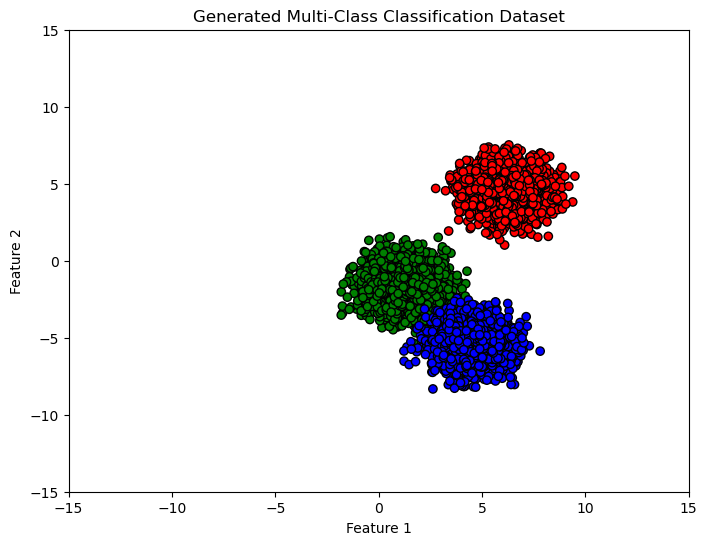

In [4]:
def generate_blobs(n_samples=[100,100,100], n_test_samples=1000, n_features=2, cluster_std=1.0, random_state=None):
    n_clusters = len(n_samples)
    if random_state is not None:
        np.random.seed(random_state)
    
    X_train, X_test = [], []
    y_train, y_test = [], []
    
    
    for i in range(n_clusters):
        center = np.random.uniform(-8, 8, size=n_features)
        train_samples = np.random.normal(loc=center, scale=cluster_std, size=(n_samples[i], n_features))
        test_samples = np.random.normal(loc=center, scale=cluster_std, size=(n_test_samples, n_features))

        X_train.append(train_samples)
        y_train.append(np.full(n_samples[i], i))
        
        #add label noise by flipping label with probability 0.1
        #for j in range(n_samples[i]):
        #    if np.random.uniform() < 0.01:
        #        y_train[i][j] = (i+1)%n_clusters

        X_test.append(test_samples)
        y_test.append(np.full(n_test_samples, i))
    
    X_train = np.vstack(X_train)
    y_train = np.hstack(y_train)

    X_test = np.vstack(X_test)
    y_test = np.hstack(y_test)

    return X_train, y_train, X_test, y_test

# Example usage
X_train, y_train, X_test, y_test = generate_blobs(n_samples=[2000,2000,2000], n_test_samples = 1000, n_features=2, cluster_std=1.0, random_state=92)

# Plotting the generated blobs
plt.figure(figsize=(8, 6))
cmap0 = matplotlib.colors.ListedColormap(['red', 'green','blue'])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap0, marker='o', edgecolor='k')
plt.title('Generated Multi-Class Classification Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.ylim(-15, 15)
plt.xlim(-15, 15)
plt.show()

def create_train_dataset(n_samples=[1000,1000,1000], n_test_samples=1000, n_features=2, n_clusters=3, cluster_std=1.0, random_state=None):
    y_train_list = []
    X_train, y_train, X_test, y_test = generate_blobs(n_samples=n_samples, n_test_samples=n_test_samples, n_features=n_features, cluster_std=cluster_std, random_state=random_state)
    train_datasets, test_datasets = [], []
    for i in range(n_clusters):
        X_i = torch.tensor(X_train[y_train == i]).float()
        y_i = torch.tensor(y_train[y_train == i]).long()
        y_train_list.append(y_i)
        train_data_i = torch.utils.data.TensorDataset(X_i, y_i)
        train_datasets.append(train_data_i)

        X_i_test = torch.tensor(X_test[y_test == i]).float()
        y_i_test = torch.tensor(y_test[y_test == i]).long()
        test_data_i = torch.utils.data.TensorDataset(X_i_test, y_i_test)
        test_datasets.append(test_data_i)
    
    return train_datasets, test_datasets, y_train_list, y_test


In [5]:
def split_data(dataset,n_parts):
    dataset_length = len(dataset)
    splits = np.array_split(np.arange(dataset_length), n_parts)
    dataset_sizes = [len(split) for split in splits]
    client_datasets = torch.utils.data.random_split(dataset, lengths=dataset_sizes)
    return client_datasets

def get_label_distribution(dataset,n_labels):
    #get the distribution of labels in a dataset and return a vector with the fraction of samples for each label
    labels = []
    for data in dataset:
        labels.append(data[1].item())
    labels = np.array(labels)
    label_distribution = np.zeros(n_labels)
    for i in range(n_labels):
        label_distribution[i] = np.sum(labels==i)
    label_distribution = label_distribution/np.sum(label_distribution)
    return label_distribution

(-15.0, 15.0)

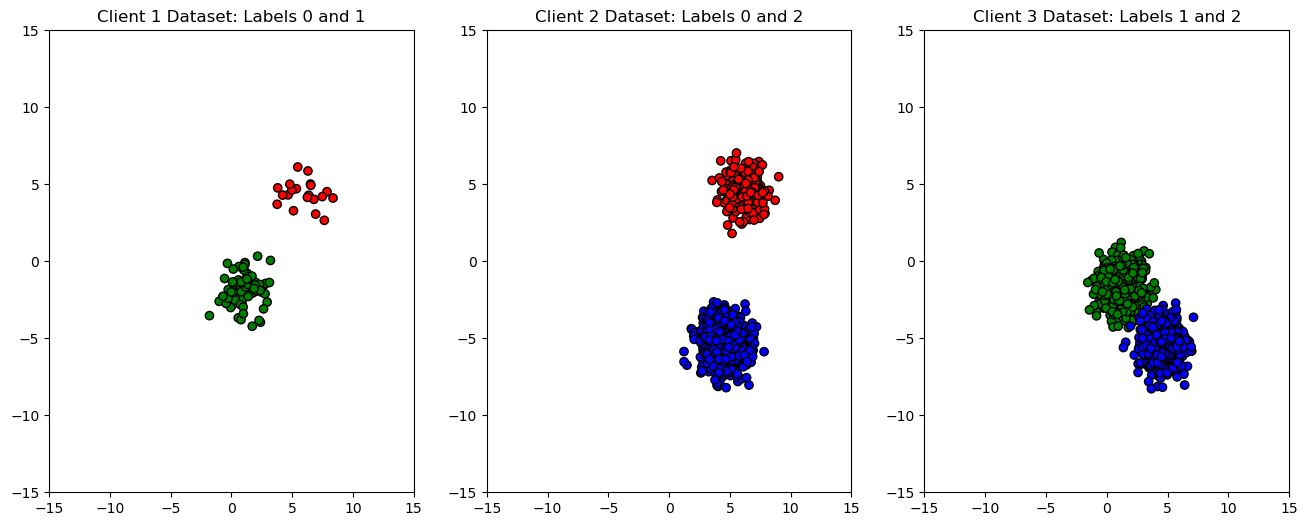

In [6]:
train_datasets, test_datasets, y_train_list, y_test = create_train_dataset(n_samples=[2000,2000,2000], n_features=2, n_clusters=3, cluster_std=1.0, random_state=92)

n_parts = 2
train_data_0 = split_data(train_datasets[0], n_parts)
train_data_1 = split_data(train_datasets[1], n_parts)
train_data_2 = split_data(train_datasets[2], n_parts)


c1_dataset_0 = Subset(train_data_0[0], np.random.choice(len(train_data_0[0]), 20, replace=False))
c1_dataset_1 = Subset(train_data_1[0], np.random.choice(len(train_data_1[0]), 80, replace=False))
c1_dataset = torch.utils.data.ConcatDataset([c1_dataset_0, c1_dataset_1])

c2_dataset_0 = Subset(train_data_0[1], np.random.choice(len(train_data_0[1]), 200, replace=False))
c2_dataset_2 = Subset(train_data_2[0], np.random.choice(len(train_data_2[0]), 800, replace=False))
c2_dataset = torch.utils.data.ConcatDataset([c2_dataset_0, c2_dataset_2])

c3_dataset_1 = Subset(train_data_1[1], np.random.choice(len(train_data_1[1]), 500, replace=False))
c3_dataset_2 = Subset(train_data_2[1], np.random.choice(len(train_data_2[1]), 500, replace=False))
c3_dataset = torch.utils.data.ConcatDataset([c3_dataset_1, c3_dataset_2])

cmap1 = matplotlib.colors.ListedColormap(['red', 'green']) # (0,1)
cmap2 = matplotlib.colors.ListedColormap(['red', 'blue']) # (0,2)
cmap3 = matplotlib.colors.ListedColormap(['green', 'blue']) # (1,2)

#plot client datasets
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
X_c1 = torch.stack([data[0] for data in c1_dataset]).numpy()
y_c1 = torch.stack([data[1] for data in c1_dataset]).numpy()
plt.scatter(X_c1[:, 0], X_c1[:, 1], c=y_c1, cmap=cmap1, marker='o', edgecolor='k')
plt.title('Client 1 Dataset: Labels 0 and 1')
plt.xlim(-15, 15)
plt.ylim(-15, 15)

plt.subplot(1, 3, 2)
X_c2 = torch.stack([data[0] for data in c2_dataset]).numpy()
y_c2 = torch.stack([data[1] for data in c2_dataset]).numpy()
plt.scatter(X_c2[:, 0], X_c2[:, 1], c=y_c2, cmap=cmap2, marker='o', edgecolor='k')
plt.title('Client 2 Dataset: Labels 0 and 2')
plt.xlim(-15, 15)
plt.ylim(-15, 15)

plt.subplot(1, 3, 3)
X_c3 = torch.stack([data[0] for data in c3_dataset]).numpy()
y_c3 = torch.stack([data[1] for data in c3_dataset]).numpy()
plt.scatter(X_c3[:, 0], X_c3[:, 1], c=y_c3, cmap=cmap3, marker='o', edgecolor='k')
plt.title('Client 3 Dataset: Labels 1 and 2')
plt.xlim(-15, 15)
plt.ylim(-15, 15)

In [7]:
y_c1 = get_label_distribution(c1_dataset,n_labels=3)
y_c2 = get_label_distribution(c2_dataset,n_labels=3)
y_c3 = get_label_distribution(c3_dataset,n_labels=3)
#create matrix of y_c1 and y_c2
source_labels = torch.tensor(np.array([y_c1,y_c2]).T)
target_labels = torch.tensor(y_c3)
source_labels

tensor([[0.2000, 0.2000],
        [0.8000, 0.0000],
        [0.0000, 0.8000]], dtype=torch.float64)

In [8]:
target_labels

tensor([0.0000, 0.5000, 0.5000], dtype=torch.float64)

In [9]:
a = torch.tensor(np.array([0.5,0.5]))
torch.matmul(source_labels,a)

tensor([0.2000, 0.4000, 0.4000], dtype=torch.float64)

In [10]:

torch.norm(target_labels - torch.matmul(source_labels,a),p=2)

tensor(0.2449, dtype=torch.float64)

In [11]:
client_datasets = [c1_dataset, c2_dataset, c3_dataset]
bs=32
client_loaders = [torch.utils.data.DataLoader(client_dataset, batch_size=bs, shuffle=True) for client_dataset in client_datasets]


#c1_dataset = torch.utils.data.ConcatDataset([train_data_0[0], train_data_1[0]])
#c2_dataset = torch.utils.data.ConcatDataset([train_data_0[1], train_data_2[0]])
#c3_dataset = torch.utils.data.ConcatDataset([train_data_1[0], train_data_2[1]])
#client_datasets = [c1_dataset, c2_dataset, c3_dataset]
#bs = 32
#client_loaders = [torch.utils.data.DataLoader(client_dataset, batch_size=bs, shuffle=True) for client_dataset in client_datasets]

test_data = torch.utils.data.ConcatDataset(test_datasets)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=bs, shuffle=True)

In [12]:
origin_model = MLP(2, 10, 3)
print(origin_model)

MLP(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
  (activation): ReLU()
)


In [13]:
n_communication = 300
num_local_epochs = 10

model_fed = copy.deepcopy(origin_model)
criterion = nn.CrossEntropyLoss()
clients_fed = []
n_clients = len(client_loaders)
print('Number of clients: ', n_clients)
val_loader = None
lr = 0.01
wd = 0.0

for i in range(n_clients):
    clients_fed.append(FederatedClient(copy.deepcopy(origin_model), criterion, client_loaders[i], val_loader))


model_fedavg, train_loss_fedavg, train_acc_fedavg, test_acc_fedavg = train_fed(n_communication, num_local_epochs, clients_fed, lr, test_loader, wd=0.0, optimize_alpha_bool=False, target_labels=None, source_labels=None)

clients_fed = []
for i in range(n_clients):
    clients_fed.append(FederatedClient(copy.deepcopy(origin_model), criterion, client_loaders[i], val_loader))

model_fedalpha, train_loss_fedalpha, train_acc_fedalpha, test_acc_fedalpha = train_fed(n_communication, num_local_epochs, clients_fed, lr, test_loader, wd=0.0, optimize_alpha_bool=True, target_labels=target_labels, source_labels=source_labels)


Number of clients:  3
[100, 1000]
[0.09090909 0.90909091]
Round 0
[0.84635524 0.16956585] 0.5024782383051727
[0.80612938 0.22491452] 0.45320150981025226
[0.76755054 0.27764418] 0.40738539248409494
[0.73119622 0.32696729] 0.3659540700680448
[0.69776717 0.37195104] 0.3299289673074758
[0.66800412 0.41164053] 0.3002371364088612
[0.64251316 0.44529911] 0.27738626107155967
[0.62155896 0.47267701] 0.2611452821863737
[0.60496539 0.49412088] 0.2505017771634446
[0.59220292 0.51043157] 0.24400674714224707
Round 1
[0.8483576  0.16749804] 0.5045522451432017
[0.80802324 0.22290072] 0.4551531271989657
[0.76931855 0.27571528] 0.40917994154950316
[0.73281604 0.32516175] 0.3675507184580401
[0.6992132  0.37031233] 0.33128558066582037
[0.66925264 0.41020968] 0.30132104878869204
[0.64355064 0.44410292] 0.2781891277691682
[0.62238896 0.47171851] 0.2616926702820738
[0.60560851 0.49337948] 0.250846859634214
[0.59268977 0.50987244] 0.24421093048489673
Round 2
[0.37823166 0.64748481] 0.3110846965208602
[0.41921

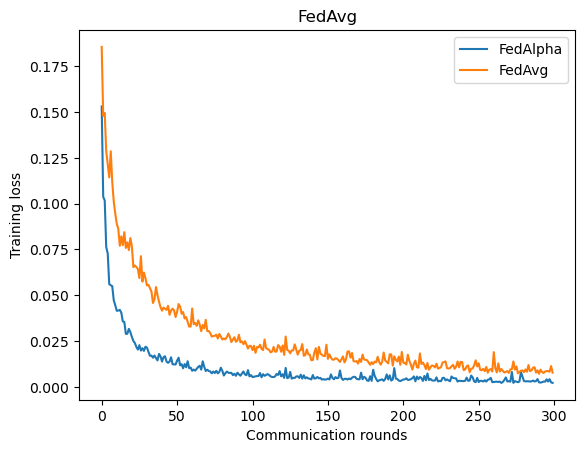

In [14]:
plt.plot(train_loss_fedalpha)
plt.plot(train_loss_fedavg)
plt.xlabel('Communication rounds')
plt.ylabel('Training loss')
plt.title('FedAvg')
plt.legend(['FedAlpha', 'FedAvg'])

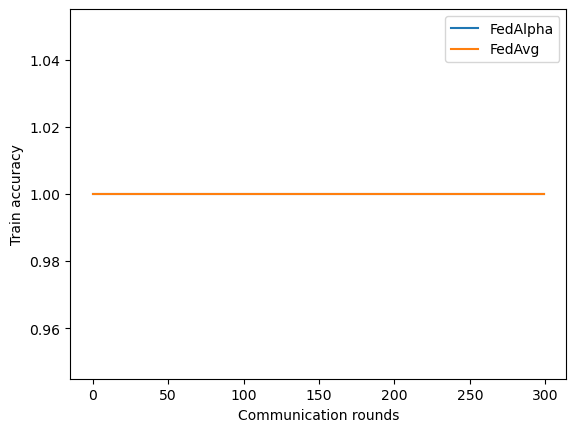

In [15]:
plt.plot(train_acc_fedalpha)
plt.plot(train_acc_fedavg)
plt.xlabel('Communication rounds')
plt.ylabel('Train accuracy')
plt.legend(['FedAlpha', 'FedAvg'])

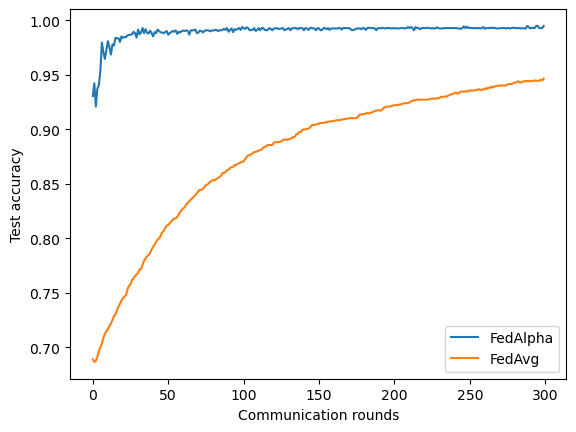

In [16]:
plt.plot(test_acc_fedalpha)
plt.plot(test_acc_fedavg)
plt.xlabel('Communication rounds')
plt.ylabel('Test accuracy')
plt.legend(['FedAlpha', 'FedAvg'])

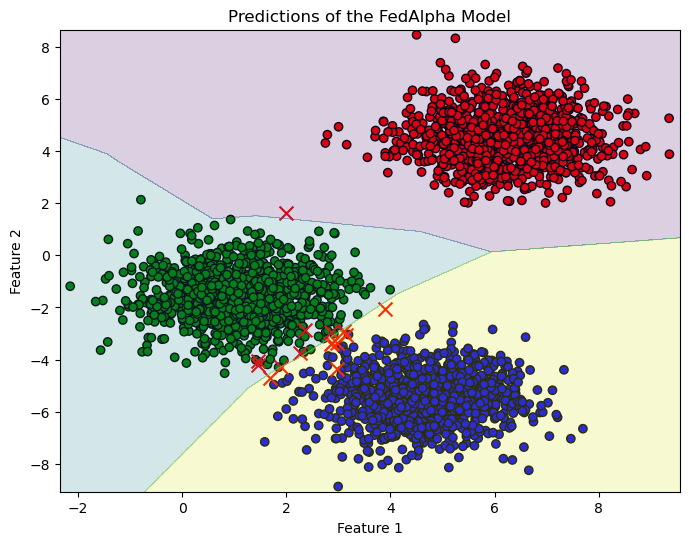

In [19]:
#plot predictions and decision boundary
X_test = torch.stack([data[0] for data in test_data]) #test_data
y_test = torch.stack([data[1] for data in test_data]).numpy()
model = model_fedalpha
with torch.no_grad():
    y_pred = model(X_test).argmax(1)
    y_pred = y_pred.numpy()

    y_pred_correct_idxs = y_pred == y_test
    y_pred_wrong_idxs = y_pred != y_test

    X_test = X_test.numpy()
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test[y_pred_correct_idxs, 0], X_test[y_pred_correct_idxs, 1], c=y_pred[y_pred_correct_idxs], cmap=cmap0, marker='o', edgecolor='k')
    plt.scatter(X_test[y_pred_wrong_idxs, 0], X_test[y_pred_wrong_idxs, 1], c='r', marker='x', s=100)

    #plot decision boundary

    x1_min, x1_max = X_test[:,0].min()-0.2, X_test[:,0].max()+0.2
    x2_min, x2_max = X_test[:,1].min()-0.2, X_test[:,1].max()+0.2
    xx,yy = np.meshgrid(np.arange(x1_min, x1_max, 0.01), np.arange(x2_min, x2_max, 0.01))
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max]
    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float())
    Z = Z.argmax(1).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.2)


    plt.title('Predictions of the FedAlpha Model')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()